### Example from o1-preview:
Modified to match the packages that is installed in the decifer_env

In [1]:
from pymatgen.io.cif import CifParser
parser_from_string = CifParser.from_str
from dscribe.descriptors import SOAP
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from ase.io import read

from scipy.spatial.distance import pdist, squareform

# Find cifs:
cifs = glob("../data/chili100k/raw/*.cif")

# Because we have paths, we use this
structure1 = CifParser(cifs[0]).parse_structures()[0].to_ase_atoms()
structure2 = CifParser(cifs[1]).parse_structures()[0].to_ase_atoms()

# If we had strings, we would use this
# structure1 = parser_from_string(cifs[0]).get_structures()[0].to_ase_atoms()
# structure2 = parser_from_string(cifs[1]).get_structures()[0].to_ase_atoms()

# Get the unique atomic numbers (species)
species = sorted(set(structure1.get_atomic_numbers()).union(structure2.get_atomic_numbers()))

# Initialize the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=6.0,
    n_max=3,
    l_max=3,
    sigma=0.5,
    sparse=False,
    average="inner",
)

soap_structure_1 = soap.create(structure1)
print(soap_structure_1.shape)
soap_structure_2 = soap.create(structure2)
print(soap_structure_2.shape)

soap_structures = np.vstack([soap_structure_1, soap_structure_2])
distance_matrix = squareform(pdist(soap_structures))
print("Distance matrix: structure1 - structure2: ")
print(distance_matrix)

(1200,)
(1200,)
Distance matrix: structure1 - structure2: 
[[ 0.         16.86480057]
 [16.86480057  0.        ]]


/home/dev/miniconda3/envs/decifer_env/lib/python3.9/site-packages/pymatgen/io/cif.py:1259: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(


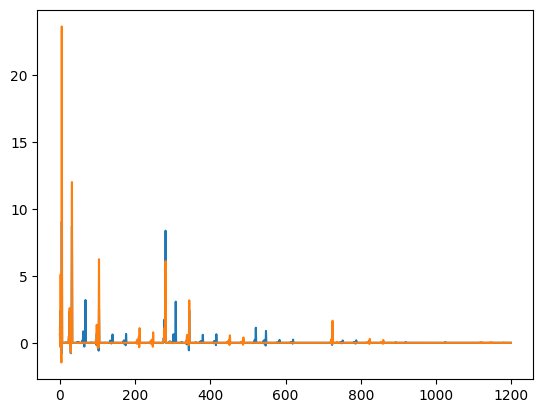

In [2]:
plt.plot(soap_structure_1)
plt.plot(soap_structure_2)

In [3]:
soap_structure_1.shape

(1200,)

In [4]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.cli import tqdm

import random
random.shuffle(cifs)
cif_files_a = cifs[:10000] # ["dataset_a_struct1.cif", "dataset_a_struct2.cif", ...]
cif_files_b = cifs[:10000] # ["dataset_b_struct1.cif", "dataset_b_struct2.cif", ...]
random.shuffle(cif_files_a)
random.shuffle(cif_files_b)

# Ensure both datasets have the same length
assert len(cif_files_a) == len(cif_files_b), "Datasets must have the same number of structures."

# Parse structures from both datasets
structures_a = []
structures_b = []
pbar = tqdm(total = len(cif_files_a), desc='Parsing structures')
for cif_a, cif_b in zip(cif_files_a, cif_files_b):
    try:
        struc1 = read(cif_a)
        struc2 = read(cif_b)
        structures_a.append(struc1)
        structures_b.append(struc2)
    except:
        pbar.update(1)
        continue
    pbar.update(1)
pbar.close()

structures = structures_a + structures_b

# Update the species list
species_set = set()
pbar = tqdm(total = len(structures), desc='Updating species list')
for struct in structures:
    species_set.update(struct.get_atomic_numbers())
    pbar.update(1)
pbar.close()
species = sorted(species_set)

# Re-initialize the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=6.0,
    n_max=2,
    l_max=2,
    sigma=0.5,
    sparse=False,
    average="inner"
)

Updating species list: 100%|██████████████████████████████████████████████████| 19952/19952 [00:00<00:00, 157491.63it/s]


In [5]:
# Compute distances between corresponding pairs
distances = []
soaps_a = []
soaps_b = []
pbar = tqdm(total = len(structures_a), desc='Calculating distances')
for struct_a, struct_b in zip(structures_a, structures_b):

    soap_a = soap.create(struct_a)
    soap_b = soap.create(struct_b)
    soaps_a.append(soap_a)
    soaps_b.append(soap_b)
    distances.append(np.dot(soap_a, soap_b) / np.sqrt(np.dot(soap_a, soap_a) * np.dot(soap_b, soap_b)))
    # distances.append(np.linalg.norm(soap_a - soap_b))
    pbar.update(1)
pbar.close()

# Calculate statistics
mean_distance = np.mean(distances)
std_distance = np.std(distances)

print(f"Mean distance between corresponding structures: {mean_distance:.4f}")
print(f"Standard deviation: {std_distance:.4f}")

Calculating distances: 100%|████████████████████████████████████████████████████████| 9976/9976 [01:50<00:00, 90.36it/s]

Mean distance between corresponding structures: 0.2177
Standard deviation: 0.3244


In [6]:
len(distances)

9976

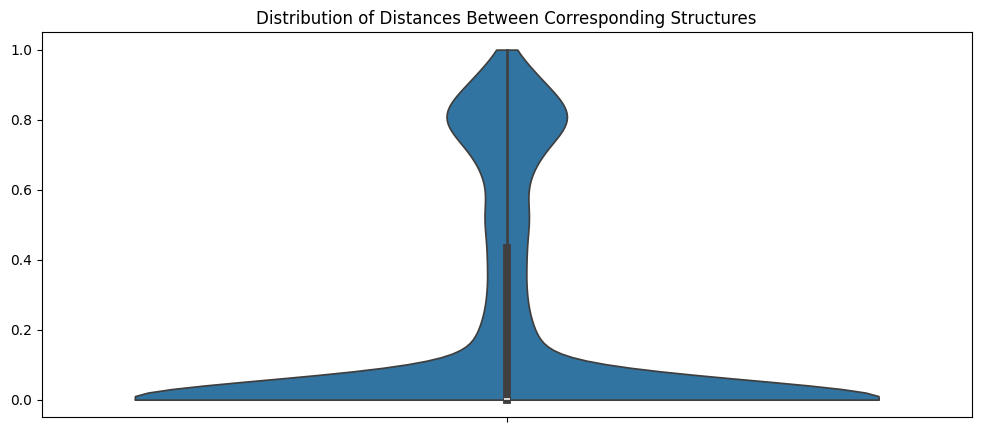

In [7]:
import seaborn as sns
import pandas as pd

# Plot histogram
fig, ax = plt.subplots(figsize=(12, 5))
# ax.violinplot(distances, bins=50, edgecolor='black')
sns.violinplot(data=distances, cut=0, ax=ax)
# ax.set_xlabel("Euclidean Distance")
# ax.set_ylabel("Frequency")
ax.set_title("Distribution of Distances Between Corresponding Structures")
# ax.axvline(np.mean(distances), color='red', linestyle='dashed', linewidth=1, label=f'Mean = {np.mean(distances):.2f}')
# ax.axvline(np.median(distances), color='green', linestyle='dashed', linewidth=1, label=f'Median = {np.median(distances):.2f}')
# ax.set_yscale('log')
plt.show()

In [ ]:
from scipy.spatial.distance import pdist

# Compute pairwise distances within the sample dataset
pairwise_distances = pdist(soaps_a, metric='euclidean')
pairwise_distances

In [ ]:
mean_distance = np.mean(pairwise_distances)
mean_distance

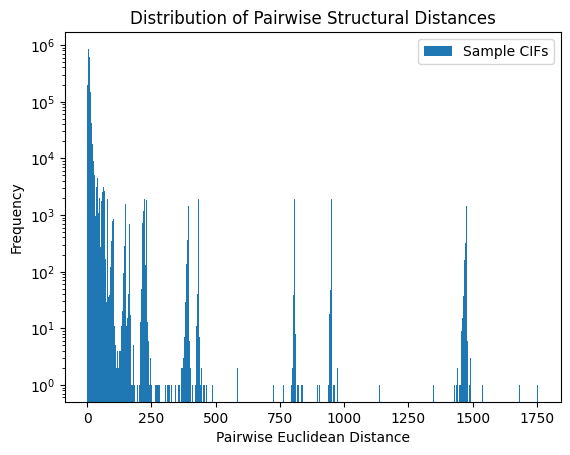

In [68]:
import matplotlib.pyplot as plt

plt.hist(pairwise_distances, bins=500, label='Sample CIFs')
plt.xlabel('Pairwise Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Structural Distances')
plt.legend()
plt.yscale('log')
plt.show()


In [21]:
from sklearn.decomposition import PCA
n_components = 2  # Adjust based on explained variance or practical constraints
pca = PCA(n_components=n_components)
reduced_soap_vectors = pca.fit_transform(soaps_b)

In [25]:
import seaborn as sns

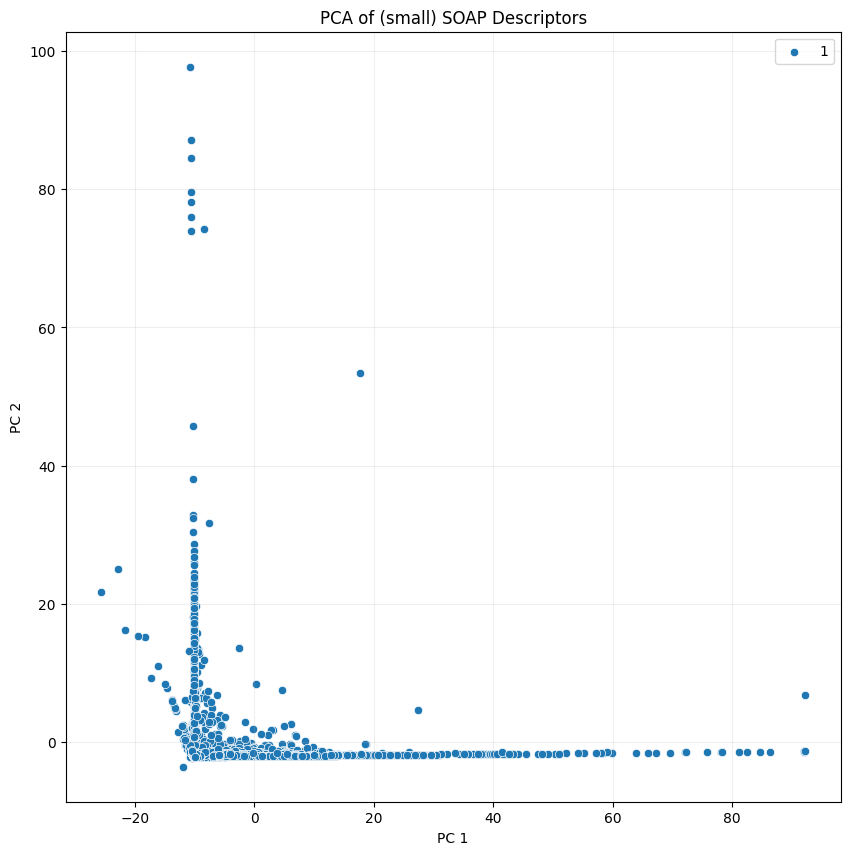

In [35]:
reduced_soap_vectors_within = reduced_soap_vectors[np.linalg.norm(reduced_soap_vectors, axis=-1) < 100]

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = reduced_soap_vectors_within[:,0], y = reduced_soap_vectors_within[:,1], label='1')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('PCA of (small) SOAP Descriptors')
ax.legend()
ax.grid(alpha=0.2)
plt.show()

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(np.array(soaps_a))

In [36]:
tsne_results

array([[-10.916836 , -30.661505 ],
       [  7.5042453,  42.162125 ],
       [ 32.01418  , -33.058956 ],
       ...,
       [-81.36543  ,   2.8758795],
       [-36.908497 , -52.92943  ],
       [ 39.366623 ,  -9.072391 ]], dtype=float32)

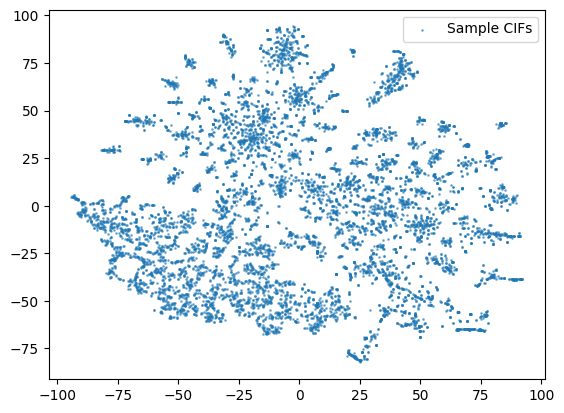

In [11]:
tsne_results_within = tsne_results[np.linalg.norm(tsne_results, axis=-1) < 1000]

# Plot the PCA results
plt.scatter(tsne_results_within[:, 0], tsne_results_within[:, 1], s=1, alpha=0.5, label='Sample CIFs')
plt.legend()
plt.show()

In [39]:
import umap

ModuleNotFoundError: No module named 'umap'

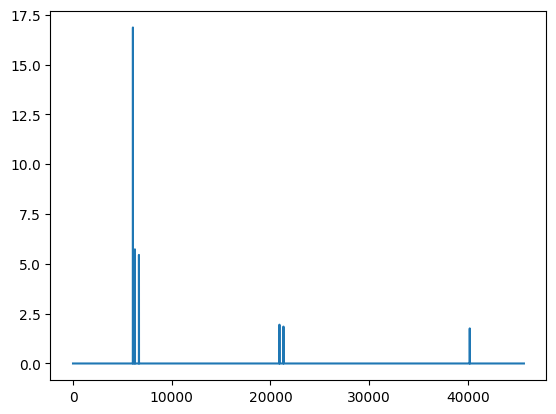

In [12]:
plt.plot(soap_a)

In [8]:
import pandas as pd

In [13]:
pd.read_parquet("../testing_small_large_soap/test_dataset_name.eval")

,cif_gen,spacegroup,species,index,rep,dataset_name,model_name,seq_len,cif_sample,spacegroup_sample,...,composition.Ba,composition.B,composition.K,composition.Be,composition.Pb,composition.Tm,composition.Rh,composition.Mn,composition.Cr,composition.N
0,data_Tl2Hg4Bi2\nloop_\n_atom_type_symbol\n_ato...,Immm,"[Hg, Bi, Tl]",6,0,test_dataset_name,default_model,328.0,# generated using pymatgen\ndata_TlHg2Bi\nloop...,Immm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data_Rb4V4P4O20\nloop_\n_atom_type_symbol\n_at...,P2_12_12_1,"[O, V, Rb, P]",12,0,test_dataset_name,default_model,534.0,# generated using pymatgen\ndata_RbVPO5\nloop_...,P2_12_12_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data_Y1Cu2S2\nloop_\n_atom_type_symbol\n_atom_...,P-3m1,"[Y, S, Cu]",15,0,test_dataset_name,default_model,330.0,# generated using pymatgen\ndata_Y(CuS)2\nloop...,P-3m1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data_Nd8In4Hg4\nloop_\n_atom_type_symbol\n_ato...,Fm-3m,"[Nd, Hg, In]",7,0,test_dataset_name,default_model,328.0,# generated using pymatgen\ndata_Nd2InHg\nloop...,Fm-3m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data_Rb12I4O20\nloop_\n_atom_type_symbol\n_ato...,Pnna,"[I, O, Rb]",19,0,test_dataset_name,default_model,439.0,# generated using pymatgen\ndata_Rb3IO5\nloop_...,Pnna,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,data_Li4Al2Ni2O8\nloop_\n_atom_type_symbol\n_a...,Pmn2_1,"[Ni, Li, Al, O]",16,0,test_dataset_name,default_model,462.0,# generated using pymatgen\ndata_Li2AlNiO4\nlo...,Pmn2_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,None,None,None,9,0,None,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,data_Na8Ca8Al8F48\nloop_\n_atom_type_symbol\n_...,P2_1/c,"[F, Na, Al, Ca]",5,0,test_dataset_name,default_model,929.0,# generated using pymatgen\ndata_NaCaAlF6\nloo...,P2_1/c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,data_Al4Cu2Cl16\nloop_\n_atom_type_symbol\n_at...,P2_1/c,"[Cl, Al, Cu]",8,0,test_dataset_name,default_model,438.0,# generated using pymatgen\ndata_Al2CuCl8\nloo...,P2_1/c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,data_Li8Mg4In4\nloop_\n_atom_type_symbol\n_ato...,Fm-3m,"[Li, Mg, In]",10,0,test_dataset_name,default_model,328.0,# generated using pymatgen\ndata_Li2MgIn\nloop...,Fm-3m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7188.111597208287


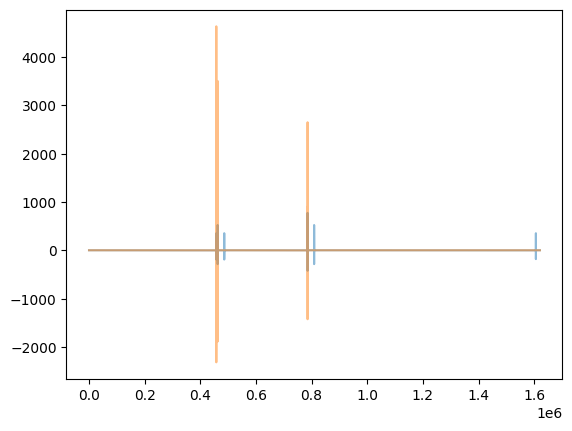

In [10]:
gen_soap = pd.read_parquet("../testing_refactored/test_name.eval")['descriptors.soap_gen'][3]
sample_soap = pd.read_parquet("../testing_refactored/test_name.eval")['descriptors.soap_sample'][3]
plt.plot(sample_soap, alpha=0.5)
plt.plot(gen_soap, alpha=0.5)
print(np.linalg.norm(sample_soap - gen_soap))